In [56]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import copy
import time

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
from sklearn.preprocessing import LabelEncoder

from DensityEstimator import GMMDensity
from Problem import get_problem

from Explainer import Explainer

def preprocessing():
    dataset = pd.read_csv('C:/Users/kylei/OneDrive/Python Scripts/NSF REU Explainability/prototype cf/german_credit_data.csv').drop('Unnamed: 0', axis = 1)
    
    dataset.dropna(axis=0, how='any', thresh=None, subset=None, inplace=True)
    
    lb = LabelEncoder()
    
    for column in dataset.columns:
        if dataset[column].dtype != np.dtype('int64'):
            dataset[column] = lb.fit_transform(dataset[column])
            
    return dataset

def train_model(x, y, model):
        cv = KFold(n_splits = 3, random_state = None)
        global total_cm
        total_cm = np.zeros((2,2))
        metric_dict = {}
        split_dict = {}
        
        it = 0
        for train_ind, test_ind in cv.split(x):
            x_train, x_test = x[train_ind], x[test_ind]
            y_train, y_test = y[train_ind], y[test_ind]
            
            model.fit(x_train, y_train)
            y_pred = model.predict(x_test)
            
            total_cm += confusion_matrix(y_test, y_pred)
            
            metrics = [accuracy_score(y_test, y_pred) *100, 
                       precision_score(y_test, y_pred)*100,
                       recall_score(y_test, y_pred)*100]
            
            metrics = np.round(metrics, decimals = 2)
            
            metric_dict[it] = metrics
            split_dict[it] = (train_ind, test_ind)
            it += 1
            
        return total_cm, metric_dict, split_dict

def find_samples(x_test, model, borderline):
    '''Borderline is a bool var that determines whether to find confident or 
        borderline samples based on predictions'''

    predictions = model.predict_proba(x_test)
    indices = []

    if borderline:
        it = 0
        for i in predictions:
            if i[0] <= .55 and i[0] >= .50 and it not in indices:
                indices.append(it)
            elif i[1] <= .50 and i[1] >= .50 and it not in indices:
                indices.append(it)
            else:
                pass

            it+=1

    if not borderline:
        it = 0
        for i in predictions:
            if i[0] >= .80 and it not in indices:
                indices.append(it)
            elif i[1] >= .80 and it not in indices:
                indices.append(it)
            else:
                pass
    
            it+=1

    sample_pool = x_test[indices]
    x_orig = copy.deepcopy(sample_pool[0])
    x_orig_y = copy.deepcopy(predictions[indices[0]])

    change_class = np.argmin(predictions[indices[0]]) #Change to opposite class

    return x_orig, x_orig_y, change_class

#%%
'''Begin main execution'''
if __name__ == '__main__':
    global input_shape

    dataset = preprocessing()

    model = RandomForestClassifier(n_estimators = 100, criterion = 'entropy')
    model2 = LogisticRegression(max_iter = 1000)

    cols = dataset.iloc[:,:-1].columns.values
    class_names = ['Bad Risk', 'No Risk']
    X = dataset.drop(dataset.columns[-1], axis = 1).values
    Y = dataset.iloc[:, [-1]].values.reshape(-1,)
    
    cm, metrics, splits = train_model(X, Y, model)
    train_model(X, Y, model2)
    
    x_train, x_test = X[splits[0][0]],  X[splits[0][1]]
    y_train, y_test = Y[splits[0][0]],  Y[splits[0][1]]

    '''Precomputing required density elements'''
 
    x_orig, x_orig_y, change_class = find_samples(x_test, model, False)
    change_class = np.argmin(x_orig_y)
    
    
    #%%
    explainer = Explainer(X, Y, model)
    res = explainer.explain_instance(sample = x_orig,
                                     change_class = change_class,
                                     plausible = True,
                                     method = 'NSGA2',
                                     method_params = None)
    
    '''
    explainer2 = Explainer(X, Y, model2)
    res2 = explainer2.explain_instance(sample = x_orig,
                                     change_class = change_class,
                                     plausible = True,
                                     method = 'NSGA2',
                                     method_params = None)
    '''


    #%%
    

C:\Users\kylei\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:882: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  f"KMeans is known to have a memory leak on Windows "
C:\Users\kylei\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:882: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  f"KMeans is known to have a memory leak on Windows "


n_gen |  n_eval |   cv (min)   |   cv (avg)   |  n_nds  |     eps      |  indicator  
    1 |      40 |  0.00000E+00 |  0.415955833 |       4 |            - |            -
    2 |      60 |  0.00000E+00 |  0.054095147 |       4 |  0.074830200 |        nadir
    3 |      80 |  0.00000E+00 |  0.002500000 |       6 |  0.728519313 |        ideal
    4 |     100 |  0.00000E+00 |  0.00000E+00 |       5 |  0.233612752 |        ideal
    5 |     120 |  0.00000E+00 |  0.00000E+00 |       6 |  0.153846154 |        ideal
    6 |     140 |  0.00000E+00 |  0.00000E+00 |      10 |  0.044530350 |            f
    7 |     160 |  0.00000E+00 |  0.00000E+00 |      11 |  0.024982588 |            f
    8 |     180 |  0.00000E+00 |  0.00000E+00 |      10 |  0.009315370 |            f
    9 |     200 |  0.00000E+00 |  0.00000E+00 |      10 |  0.298194333 |        ideal
   10 |     220 |  0.00000E+00 |  0.00000E+00 |      11 |  0.003030303 |            f
   11 |     240 |  0.00000E+00 |  0.00000E+00 |      1

In [59]:
'''Version 2 of change weight display'''
def find_change_weight(opt_result):
    algorithm = opt_result.history[-1] #Consider only final population
    F_pop = algorithm.pop.get("F") #Get objective values
    F_pop[:,[0]] = (-1)/F_pop[:,[0]] #Converting objectives back into their actual values
    F_pop[:,[1]] = F_pop[:,[1]]*-1
    X_pop = algorithm.pop.get('X').astype(int) #Get pop samples

    deltas = []
    for i in range(X_pop.shape[0]):
        deltas.append(X_pop[i] - x_orig)

    f_x = np.hstack((deltas, F_pop))

    global top5_obj1_df, top5_obj2_df, f_x_df_sliced
    new_cols = []
    for i in range(len(cols)):
        new_cols.append(str(cols[i]))
    
    format_dict = {}
    for i in new_cols:
        format_dict[i] = "{0:,.0f}"

    new_cols = np.append(new_cols, "obj1")
    new_cols = np.append(new_cols, "obj2")

    f_x_df = pd.DataFrame(data=f_x, columns = new_cols)

    f_x_df = f_x_df.sort_values(by = ["obj1"], ascending = True)
    f_x_df = f_x_df.iloc[np.r_[0:5, -10:-5],:] #Take top and bottom 5
    f_x_df = f_x_df.replace(0, np.nan)

    return f_x_df, format_dict

df, format_dict = find_change_weight(res)

df.style.format(format_dict, na_rep = "", ).hide_index()

Age,Sex,Job,Housi,Savin,Check,Credi,Durat,Purpo,obj1,obj2
15,,,,2,-1,21,-1,,0.002262,0.480000
15,,,,2,-1,-31,-1,,0.002315,0.460000
15,,,,2,-1,-31,-1,,0.002317,0.480000
15,,,,2,-1,-26,-1,,0.002619,0.490000
15,,,,2,-1,-175,-1,,0.003556,0.490000
15,,,,2,-1,-199,-20,,0.293200,0.810000
15,,,,2,-1,-54,-21,,0.309260,0.820000
14,,,,2,-1,-75,-23,,0.338106,0.830000
15,,,,2,-1,-28,-25,,0.358627,0.840000
15,,,,2,-1,18,-26,,0.376568,0.850000


Age: -0.0
Sex: -0.0
Job: -0.2551
Housi: 0.806
Savin: -0.3369
Check: 0.0393
Credi: -0.0
Durat: -11.8953
Purpo: -2.0589


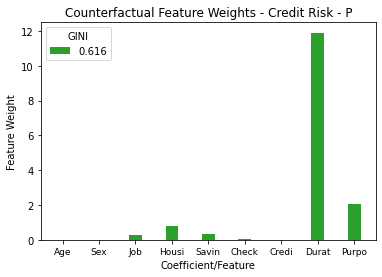

C:\Users\kylei\anaconda3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\kylei\anaconda3\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in true_divide


Your original class probability is: [0.93 0.07]
------------------------------------------------------------
Minimal change required to reach class No Risk
Need to change feature Age by: 15.3095 (69.59%)
Need to change feature Sex by: 0.1944 (inf%)
Need to change feature Job by: 0.4009 (20.05%)
Need to change feature Housi by: 0.6674 (66.74%)
Need to change feature Savin by: 2.8309 (inf%)
Need to change feature Check by: -0.1812 (-18.12%)
Need to change feature Credi by: 21.3762 (0.36%)
Need to change feature Durat by: -0.0056 (-0.01%)
Need to change feature Purpo by: 0.0081 (0.16%)
Class probability will be: [0.45 0.55]
------------------------------------------------------------
Change required to reach class No Risk with maximum probability
Need to change feature Age by: 15.757  (71.62%)
Need to change feature Sex by: 0.2115  (inf%)
Need to change feature Job by: 0.4101  (20.51%)
Need to change feature Housi by: 0.6642  (66.42%)
Need to change feature Savin by: 2.5169  (inf%)
Need t

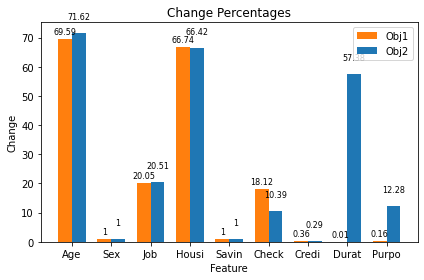

Sparsity: 0.6156973589192365


In [65]:
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler

def gini(vector):
    vec = np.sort(vector)
    N = len(vec)
    l1 = 0

    for i in vec:
        l1 += abs(i)

    summation = 0
    for i in range(N):
        b = abs(vec[i])/l1
        c = (N - (i+1) + .5)/N

        summation += sum(b*c)

    total = 1 - 2*summation

    return total

def print_delta(x_orig, x_prime_ob1, x_prime_ob2, pred1, pred2, cols):
    deltas1 = x_prime_ob1-x_orig
    percent1 = np.round(deltas1/abs(x_orig)*100,2)

    print('Your original class probability is: {base}'.format(base = x_orig_y))

    print('-'*60)

    print('Minimal change required to reach class {c}'
          .format(c=class_names[change_class]))
    for name, change, per in zip(cols, deltas1, percent1):
        print('Need to change feature {n} by: {c} ({p}%)'
              .format(c = np.round(change,4), n = name, p=per))
    print('Class probability will be: {p1}'.format(p1 = pred1))

    print('-'*60)

    print('Change required to reach class {c} with maximum probability'
          .format(c=class_names[change_class]))
    deltas2 = x_prime_ob2-x_orig
    percent2 = np.round(deltas2/abs(x_orig)*100,2)

    for name, change, per in zip(cols, deltas2, percent2):
        print('Need to change feature {n} by: {c}  ({p}%)'
              .format(c = np.round(change,4), n = name, p = per))

    print('Class probability will be: {p2}'.format(p2 = pred2))

    return percent1, percent2

def convert(lst):
    #Used to convert a dict sorted into a list back into a dict
    dct = {lst[i][0]: lst[i][1] for i in range(0, len(lst))}
    return dct

def find_change_weight(opt_result):
    algorithm = opt_result.history[-1] #Consider only final population

    F_pop = algorithm.pop.get("F") #Get objective values
    X_pop = algorithm.pop.get('X') #Get pop samples
    
    #Convert objectives back to their normal forms
    obj_2 = F_pop[:,[1]]*-1*100
    obj_1 = (F_pop[:,[0]]*-1)
    
    #Collect the deltas (changes)
    deltas = []
    for i in range(X_pop.shape[0]):
        deltas.append(X_pop[i] - x_orig)
    
    #Scale the deltas before regression
    deltas = StandardScaler().fit_transform(np.array(deltas))

    '''Fit the regressor to delta and obj2 and get coefficients'''
    regressor = Lasso(alpha = .3) #Intialize
    regressor.fit(deltas, obj_2) #Fit
    coef = regressor.coef_.reshape(-1,1) #Coefficients
    
    #Compute gini
    sparsity_measure = gini(coef) 
    
    #Output coefficient per feature
    for i, j in zip(cols, coef): 
        print('{c}: {co}'.format(c = i, co = np.round(j[0],4)))

    #Find the best samples and their predictions
    best_sample = X_pop[np.where(obj_2 == max(obj_2))[0][0]]
    best_sample_prediction = model.predict_proba(best_sample.reshape(1,-1)).reshape(-1)

    best_sample1 = X_pop[np.where(obj_1 == max(obj_1))[0][0]]
    best_sample1_prediction = model.predict_proba(best_sample1.reshape(1,-1)).reshape(-1)
    
    #Shorten the columns and stick them in a dictionary
    short_cols = cols
    for i in range(len(cols)):
        short_cols[i] = str(cols[i])[0:5]
    dct = {key: None for key in short_cols}
    
    #Put the coefficients into the dictionary
    for i in range(len(dct)):
        dct[short_cols[i]] = abs(coef[i][0])
    
    #Sort the dictionary by coefficient magnitude and then reconvert into a dict
    #dct = sorted(dct.items(), key=lambda x:abs(x[1]), reverse=False)
    #dct = convert(dct)
    
    #Take the coef dict keys as a list
    ticks = list(dct.keys())

    plt.bar(np.arange(0,len(dct.keys())), dct.values(), width = 0.35, color = 'tab:green')
    plt.xticks(np.arange(0,len(dct.keys())), ticks, fontsize=9)
    plt.title('Counterfactual Feature Weights - Credit Risk - P')
    #plt.axvline(x = 0, color = 'black', linestyle = '--')
    plt.xlabel('Coefficient/Feature')
    plt.ylabel('Feature Weight')
    plt.legend([np.round(sparsity_measure,3)], title='GINI')

    plt.show()

    ######################################################################
    ##                     Graphing Change Weights                      ##
    ######################################################################

    p1, p2 = print_delta(x_orig, best_sample1, best_sample,
                         best_sample1_prediction, best_sample_prediction,
                         cols)
    
    for i in range(len(p1)):
        if p1[i] == np.inf:
            p1[i] = 1

        if p2[i] == np.inf:
            p2[i] = 1

    p1 = np.round(abs(p1), 2)
    p2 = np.round(abs(p2), 2)
    x_ = np.arange(len(short_cols))
    width = 0.35

    fig, ax = plt.subplots()
    rects1 = ax.bar(x_ - width/2, p1, width, label = 'Obj1', color = 'tab:orange')
    rects2 = ax.bar(x_ + width/2, p2, width, label = 'Obj2', color = 'tab:blue')

    ax.set_ylabel('Change')
    ax.set_xlabel('Feature')
    ax.set_title('Change Percentages')
    ax.set_xticks(x_)
    ax.set_xticklabels(short_cols)
    ax.legend()

    ax.bar_label(rects1, padding = 3, fontsize = 8)
    ax.bar_label(rects2, padding = 12, fontsize = 8)

    fig.tight_layout()

    plt.show()

    print('Sparsity: {s}'.format(s = sparsity_measure))

    return coef


coef1 = find_change_weight(res)